# Cepstral Liftering



#### Cepstral Features

A cepstrogram is similar in many ways to a spectrogram. The only difference is that each 'column' in the display is a cepstral slice and not a spectral slice as in a spectrogram. 

The cepstrum is obtained by inverse DFT of the log spectral magnitude.  Thus, the units in which a cepstrum is displayed is the same as time.  In order to avoid confusion and stress the derivation from the spectrum, we call the unit now *Quefrency*.

One of the great advantages of using the cepstrum is that we can represent most of the content with a small number of cepstral
coefficients obtained by truncating the cepstrum, i.e. we only use the lowest L coefficients from the N-dim spectral magnitude vector
with L << N.   This truncated spectrum is equivalent to the smoothed spectrum.



#### Cepstral Liftering

The effect of cepstral truncation is well illustrated in this cepstral liftering demo.

The low order cepstral coefficients relate to the spectral envelope, while we often observe  a prominent peak in the slice at the point corresponding to the signal's pitch. In the cepstrogram, the series of these pitch peaks appears as a smooth contour. Furthermore there seems to be little or no information in the higher order quefrencies  except the pitch. This observation suggests an interesting operation. We can divide the cepstrum in two parts: the low quefrency components and the high quefrency components and reconstruct a spectrogram from either part by applying a DFT on the selected coefficients.

The retained low order quefrency components is often called the 'liftered' cepstrum (cepstral equivalent of low-pass filtering) and after reconstruction results in a smooth spectrogram or *envelope spectrogram*. The high order components constitute the cepstral residue and may be reconstructed to a pitch spectrogram or cepstral *residue spectrogram*. with the two resulting spectrograms by interactively liftering the cepstrogram in different places.


#### The Demo

In the GUI below, you see plots of waveform, spectrogram, cepstrogram, envelope spectrogram and residue spectrogram.

You can select the liftering point with a slider.  Move a slider to observe more or less smoothing by the liftering operation.


#### Things to explore

- what happens if the liftering point is moved close to the minimum ?
- what happens if the liftering point is moved close to the maximum ?
- which representation is most suited as feature extraction for a speech recognizer ?
- what we call here the "residue spectrogram" is sometimes called the "pitch spectrogram"; explain.

## Mel Cepstral Coefficients

We can still perform this cepstral liftering starting on the mel spectrum.   For the low resolution mel spectrum the effect is somewhat less obvious.  For the high resolution mel spectrum, the pitch smoothing effect by truncation in the cepstrum becomes obvious again.
In the demo below, just 'check' the box 'use mel-scale'.

- can you get a spectral envelope of the high resolution mel spectrum by using cepstral truncation ?
- can you get a clean pitch spectrogram from the high mel cepstral coefficients ?
- check the female voice 'coding/f2.wav'.  (mel) Cepstral smoothing is not evident, in many situations you may observe some pitch leakage into the spectral envelope.  Pls. explain why things are easier with 'misc/friendly' from an average male voice.


In [18]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [19]:
%matplotlib inline
import os,sys, math, copy
import numpy as np
import librosa

import pyspch.sp as Sps
import pyspch.core as Spch
import pyspch.display as Spd

import matplotlib.pyplot as plt
import matplotlib as mpl
import ipywidgets as widgets
from ipywidgets import interact, Layout

mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

## 1. Load a Waveform File

choose between male or female samples   
and compute a default spectrogram

In [20]:
dir = 'https://homes.esat.kuleuven.be/~spchlab/data/'
# female examples -----------
# name = 'misc/bad_bead_booed'
# name = 'misc/expansionist'
# name = 'coding/f2'
# male examples ----------
# name ='misc/b_8k'
name = 'misc/friendly'
#name = 'coding/f2'
#
wavfname = os.path.join(dir,name+".wav")
wavdata, sr = Spch.load(wavfname)
# reload and downsample for data with sample rates above 8kHz
if sr > 8000:  wavdata, sr = Spch.load(wavfname,sample_rate=8000) 
wavlength = wavdata.size/float(sr)
shift = 0.01
spgdata = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift)

In [21]:
# assumes a wavefile preloaded in *wavdata* and spectrogram precomputed in *spgdata*
#
def cepstral_lifter_plot(lifter=12,mel_flag=False):
    
    #n_mels = 20 if sr == 8000 else 24
    n_mels = 80

    #spg = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift)
    if mel_flag:
        cep = Sps.melcepstrum(S=spgdata,n_cep=n_mels,n_mels=n_mels)
    else:
        cep = Sps.cepstrum(S=spgdata)
    spg_env, spg_res =  Sps.cep_lifter(cep,n_lifter=lifter,n_spec=cep.shape[0])
    # we plot the mean normalized cepstrum for visualization reasons
    cep_n = Sps.mean_norm(cep[1:,:])
    #
    fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgdata,img_ftrs=[cep_n,spg_env,spg_res],row_heights=[1,1,1.5,1,1],sample_rate=sr,figsize=(14,8))
    fig.axes[1].set_ylabel("")
    fig.axes[2].set_title("CEPSTROGRAM")
    #fig.axes[2].set_cmap("Greys")
    fig.axes[2].plot([0.,wavlength],[lifter,lifter],lw=2)
    fig.axes[3].set_title("ENVELOPE SPECTROGRAM")
    fig.axes[4].set_title("RESIDUE SPECTROGRAM")
    display(fig)

In [22]:
widgets.interact(cepstral_lifter_plot,
         lifter=widgets.IntSlider(value=12,min=1,max=128,step=1,
                            continous_update=False,description="Cepstral Lifter",
                            layout=widgets.Layout(width='75%') ,style={'description_width':'25%'}),
         mel_flag = widgets.Checkbox(value=False,description='use mel-scale',
                            indent=True));

interactive(children=(IntSlider(value=12, description='Cepstral Lifter', layout=Layout(width='75%'), max=128, …

### 2. Fourier Spectrogram

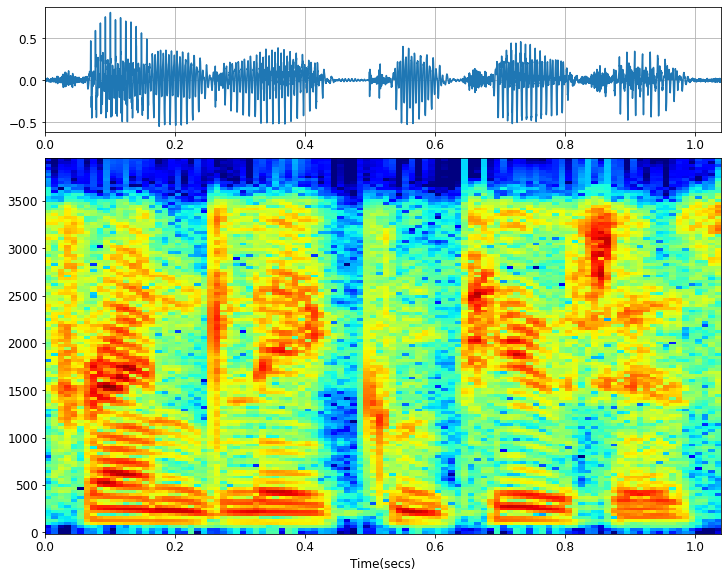

In [3]:
# compute a spectrogram as starting point for further analysis
shift=0.01
length=0.030
n_shift = int(shift*sr)
n_length = int(length*sr)
n_fft = 2**math.ceil(math.log2(n_length))
spg = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift,n_mels=None,mode='dB')
(n_param,n_frames)=spg.shape
d_freq = sr/(2.*(n_param-1))
fig = Spd.PlotSpg(wavdata=wavdata,spgdata=spg,sample_rate=sr,figsize=(10,8))
fig

In [4]:
# spectrogram with sliding window
def sliding_window_spg(iframe=1):
    fig.remove_patches()
    fig.add_vrect((iframe-1)*shift,(iframe+2)*shift,iax=0,ec=None,fill=True)
    fig.add_vrect(iframe*shift,(iframe+1)*shift,iax=1)
    display(fig)
#
frame_slider=widgets.IntSlider(min=1,max=n_frames-2,value=n_frames/2,
            description='FRAME',layout=widgets.Layout(width='6in'),readout=True )
i_spg=interactive(sliding_window_spg,iframe=frame_slider);
display(i_spg)

interactive(children=(IntSlider(value=52, description='FRAME', layout=Layout(width='6in'), max=102, min=1), Ou…

In [5]:
# spectrogram with sliding window
def sliding_window_spg(iframe=0):
    fig.remove_patches()
    fig.add_vrect((iframe-1)*shift,(iframe+2)*shift,iax=0,ec=None,fill=True)
    fig.add_vrect(iframe*shift,(iframe+1)*shift,iax=1)
    display(fig)
#
frame_slider=widgets.IntSlider(min=1,max=n_frames-2,value=n_frames/2,
            description='i',layout=widgets.Layout(width='8in'),readout=True )

i_spg = widgets.interactive_output(sliding_window_spg,{'iframe':frame_slider})
display(frame_slider,i_spg)


IntSlider(value=52, description='i', layout=Layout(width='8in'), max=102, min=1)

Output()

### 3. Mel Frequency Cepstral Coefficients


**STEP 1. Mel Spectrum**

In a first step the Fourier Spectrum is converted to a mel Spectrum.  By this the frequency axis is warped as inspired by the human auditory system.  The warping corresponds roughly in maintaining the frequency spacing at low frequencies (below 1kHz) and doing a logarithmic compression on the frequency axis as higher frequencies (above 1kHz).  A low resolution is adequate in this pipeline, given that is followed by cepstral modeling.   It is common to use 20 channels for narrowband signals (8kHz sampling rate) and 24 channels for wideband signals.

**STEP 2. Mel Cepstrum**
This is a single frame operation in which the cepstrum is computed of low dimensional representation of spectral envelope.  It can either be computed from the Fourier Spectrum or from the Mel Spectrum.   The default number of cepstral parameters is 13.  An alternative exists in replacing c0 (mean of log-energy per mel band) by the true log-energy.  We don't do this here.

**STEP 3. Delta's and Delta-Delta's**
"Delta's" compute the "trend" over time of the features and double delta's compute a second order derivative.  In practice the derivatives are approximated by simple regression formulas.

$$
\begin{align}
\Delta c_i  &= 2 c_{i+2} + c_{i+1} - c_{i-1} - 2 c_{i-2}  \\
\Delta\Delta c_i &=  \Delta c_{i+1} - \Delta c_{i-1}   
\end{align}
$$

The final feature vector is obtained by stacking instantaneous cepstral features with their delta's and delta-delta's.  Thus resulting in a 39-dimensional feature vector derived from a receptive field of 7 frames.

MFCCs are both compact and highly uncorrelated features.  This makes them suitable in almost all circumstances and for all backends. These features are the reference features for HMM/GMM based systems.  Their main drawback is the limited receptive field. 

In [24]:
# MFCCs with sliding window
def sliding_window_mfcc(iframe=0):
    fig.remove_patches()
    fig.add_vrect((iframe-1)*shift,(iframe+2)*shift,iax=0)
    fig.add_vrect(iframe*shift,(iframe+1)*shift,iax=1)
    fig.add_vrect(iframe*shift,(iframe+1)*shift,iax=2)
    fig.add_vrect(iframe*shift,(iframe+1)*shift,iax=3)
    #fig.add_vrect((iframe-3)*shift,(iframe)*shift,iax=3,alpha=.2)
    fig.add_vrect((iframe-3)*shift,(iframe+4)*shift,iax=3,alpha=.1,color='b',fill=True)
    fig.add_vrect(iframe*shift,(iframe+1)*shift,iax=4)
    #print(iframe)
    display(fig)

#
i_mfcc=interactive(sliding_window_mfcc,iframe=widgets.IntSlider(min=3,max=n_frames-4,value=n_frames/2,
            description=' ',layout=widgets.Layout(width='10.2in'),readout=False)
             );
i_mfcc

interactive(children=(IntSlider(value=52, description=' ', layout=Layout(width='10.2in'), min=3, readout=False…

### 4. High Resolution Mel Spectra (with splicing over wide window)

**STEP 1. Mel Spectrum (high resolution)**

In a first step the Fourier Spectrum is converted to a mel Spectrum.  By this the frequency axis is warped as inspired by the human auditory system.  The warping corresponds roughly in maintaining the frequency spacing at low frequencies (below 1kHz) and doing a logarithmic compression on the frequency axis as higher frequencies (above 1kHz).  The high resolution mel spectrum (+- 80 channels) preserves both spectral envelope and pitch information in a single spectral representation.  The high resolution mel spectrum should only be used as a feature vector in systems that can deal with highly correlated features.

**STEP 2. Stacking of Frames**

From a spectral analysis point of view it makes sense to use short analysis windows (30msec).  However from a speech recognition point of view, it is better to observe the short time spectrum in its context.   This is simply achieved by stacking many adjacent vectors together.

We may e.g. stack $N$ frames on the left and the right using a stride of 2 as shown below.  This results in a receptive field of $2(N*s)+1$ frames wide.  Using a stride of 2 allows for a wider span receptive field while maintaining a manageble dimension of the feature vector.  
$$
\underbrace{ 
S_{i-N\times s} \hspace{8pt} \text{...} \hspace{8pt} S_{i-s} \hspace{8pt}  S_i \hspace{8pt} S_{i+s} \hspace{8pt} \text{...} \hspace{8pt}S_{i+N\times s} }_{F_i}
$$


In the implementation below we use 80 dimensional mel spectra, we stack 5 frames to left and right and use a stride of 2 resulting in a receptive field of 210 msec and a feature vector dimension of 880.  Before splicing the mel spectral features are mean and variance normalized.

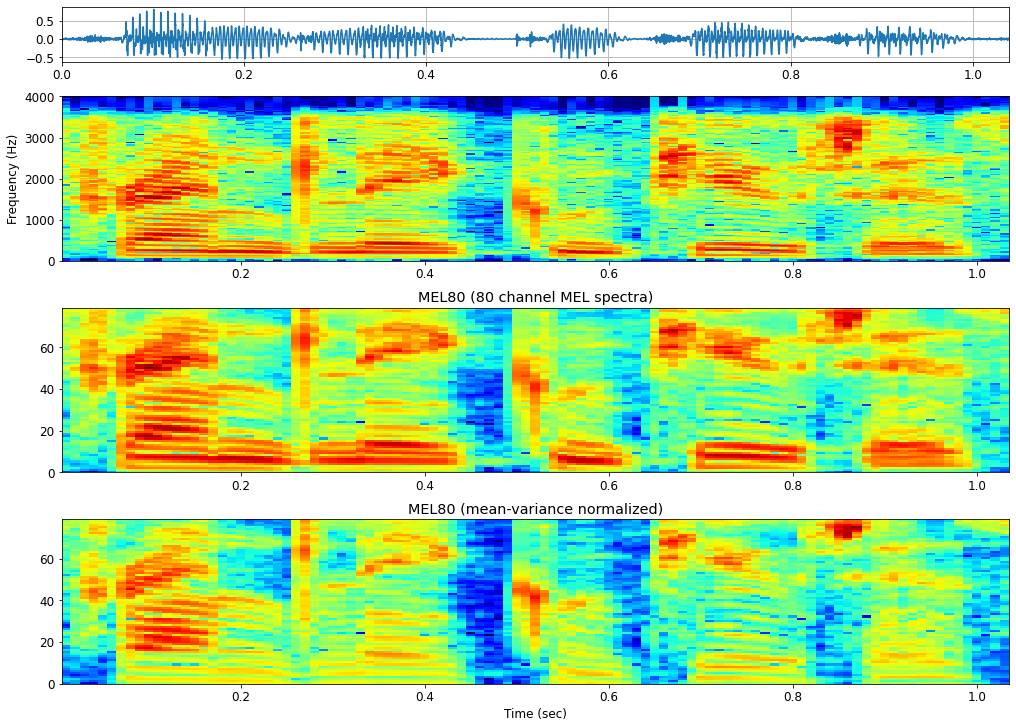

In [39]:
stride = 2
N = 5
spg = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift)
spgmel = Sps.spg2mel(spg,sample_rate=sr,n_mels=80)
spgmel_n = Sps.mean_norm(spgmel,type="meanvar")
spgmel_s = Sps.splice_frames(spgmel_n,N=N,stride=stride)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,img_ftrs=[spgmel,spgmel_n],sample_rate=sr,figsize=(14,10))
fig.axes[2].set_title("MEL80 (80 channel MEL spectra)")
fig.axes[3].set_title("MEL80 (mean-variance normalized)")
display(fig)

In [40]:
# MFCCs with sliding window
def sliding_window_mspec(iframe=0):
    fig.remove_patches()
    fig.add_vrect((iframe-1)*shift,(iframe+2)*shift,iax=0)
    fig.add_vrect(iframe*shift,(iframe+1)*shift,iax=1)
    fig.add_vrect(iframe*shift,(iframe+1)*shift,iax=2)
    #fig.add_vrect(iframe*shift,(iframe+1)*shift,iax=3)
    fig.add_vrect((iframe-N*stride)*shift,(iframe+1+N*stride)*shift,iax=3,alpha=.6,fill=True)
    display(fig)
#
i_mfcc=interactive(sliding_window_mspec,iframe=widgets.IntSlider(min=N*stride+1,max=n_frames-N*stride-2,value=n_frames/2,
            description='frame',layout=widgets.Layout(width='6in'))
             );
i_mfcc

interactive(children=(IntSlider(value=52, description='frame', layout=Layout(width='6in'), max=92, min=11), Ou…

## Feature Extraction master routine

The above feature extraction methods can be implemented in a single call

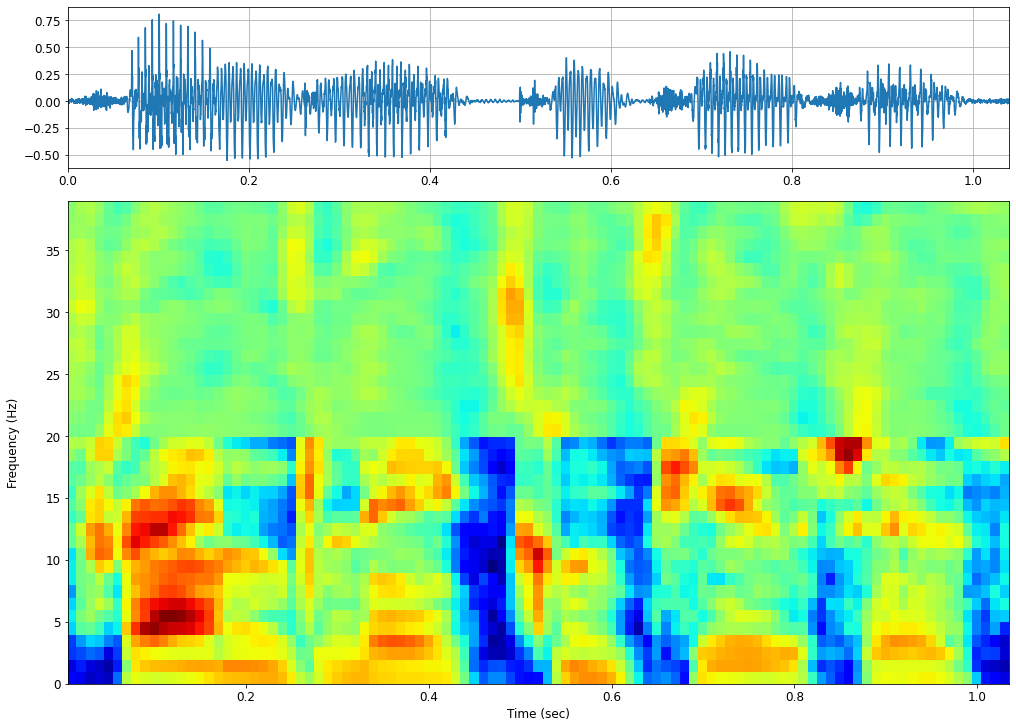

In [41]:
ftrs = Sps.feature_extraction(wavdata,sample_rate=sr,n_mels=20,Deltas="delta",Norm="mean")
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=ftrs,dy=1,sample_rate=sr,figsize=(14,10))
display(fig)

In [ ]:
## some tests with interactive_output
## not suitable in combination with spectrogram plots -- gives flickering

In [4]:
a = widgets.IntSlider()
b = widgets.IntSlider()
c = widgets.IntSlider()
ui = widgets.HBox([a, b, c])
def f(a, b, c):
    print((a, b, c))
    x=1

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})

display(ui, out)

Output()

In [5]:
ifr = widgets.IntSlider( min=0,max=n_frames-1,value=n_frames/2,description='',layout=widgets.Layout(width='10in'),readout=False )
def func(a):
    x=1
    print(a)
ifr_disp = widgets.interactive_output(func,{'a':ifr})
display(ifr_disp,widgets.HBox([ifr]) )

Output()